# Introduction

Fraud detection is critical for audit companies and financial institutions to ensure the integrity and trustworthiness of financial statements and transactions. Fraudulent activities can result in significant financial losses and reputational damage for businesses and investors. Therefore, developing accurate and effective fraud detection models is crucial to identify potential fraud cases and risks.
The main question we will try to answer in our project is: How can we build a classification model that accurately identifies fraudulent companies?
The dataset includes financial data, transactional data, company information, and external data. By leveraging this dataset, we can develop a classification model that learns patterns and characteristics associated with fraudulent companies, enabling us to accurately predict and identify potential fraud cases in the future.


# Method & Results

### Overview of Our Methods

First we will read the dataset, clean and wrangle the data, and select relevant variables for our classification model. The data will then be split into training and testing sets. Next, we will create a recipe to preprocess the data, including centering, scaling, and imputing missing values. The recipe will incorporate all predictors. To determine the optimal k value for the k-nearest neighbors (k-NN) model, we will employ 5-fold cross-validation for odd values of k from 1 to 21 and select the best-performing value. With the optimal k value, we will train the k-NN model on the entire training set, estimating decision boundaries based on the k nearest neighbors. Finally, we will evaluate the trained model on the testing set by predicting the risk class.

## EDA

### Importing Libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Downloading & Reading File

In [2]:
file_url = "https://archive.ics.uci.edu/static/public/475/audit+data.zip"
zip = download.file(file_url, "audit.zip")
unzipped = unzip("audit.zip")

print("Table 1: The dataset used for data analysis.")
audit_data = read_csv("audit_data/audit_risk.csv")
head(audit_data)
colnames(audit_data)

[1] "Table 1: The dataset used for data analysis."


New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6,⋯,0.4,0,0.2,0,4.4,17.530,0.4,0.5,3.5060,1
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,0


[1] "Sector_score"   "LOCATION_ID"    "PARA_A"         "Score_A"       
 [5] "Risk_A"         "PARA_B"         "Score_B...7"    "Risk_B"        
 [9] "TOTAL"          "numbers"        "Score_B...11"   "Risk_C"        
[13] "Money_Value"    "Score_MV"       "Risk_D"         "District_Loss" 
[17] "PROB"           "RiSk_E"         "History"        "Prob"          
[21] "Risk_F"         "Score"          "Inherent_Risk"  "CONTROL_RISK"  
[25] "Detection_Risk" "Audit_Risk"     "Risk"

<b>Table 1</b>: The dataset used for data analysis.

We downloaded and read the dataset "Audit Data" (Hooda, 2018), which will be used in building the classification model later.

### Wrangling & Cleaning

Looking at the data, it seems like it is tidy already and column types are well defined. The column names are inconsistent with case so we'll standardize it by uppercasing everything. The risk column is going to be our target class, therefore we will also change the type from dbl to factor.

In [3]:
colnames(audit_data) = toupper(colnames(audit_data))

##### Choosing predictors

Before changing the risk column to factor and examining the dataset, let's investigate the meaning of each column and see if any should be removed. Note that we have a conflict in column names right now: there are two columns named PROB.
Source: https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit

Our dataset is from Kaggle, and here's the link: https://www.kaggle.com/datasets/sid321axn/audit-data.

- <b>SECTOR_SCORE</b>: Historical risk score value of sector
- <b>LOCATION_ID</b>: Unique ID of the city/province
- <b>PARA_A</b>: Discrepancy found in the planned expenditure of inspection and summary report A in crore
- <b>SCORE_A</b>: Unknown
- <b>RISK_A</b>:  Unknown
- <b>PARA_B</b>: Discrepancy found in the planned expenditure of inspection and summary report A in crore
- <b>SCORE_B...7</b>: Unknown
- <b>RISK_B</b>: Unknown
- <b>TOTAL</b>: Total amount of discrepancy found in other reports in crore
- <b>NUMBERS</b>: Historical discrepancy score
- <b>SCORE_B...11</b>: Unknown
- <b>RISK_C</b>: Unknown
- <b>MONEY_VALUE</b>: Amount of money involved in misstatements in the past audits
- <b>SCORE_MV</b>: Unknown
- <b>RISK_D</b>: Unknown
- <b>DISTRICT_LOSS</b>: Unknown
- <b>PROB</b>: Unknown
- <b>RISK_E</b>: Unknown
- <b>HISTORY</b>: Unknown
- <b>PROB</b>: Unknown
- <b>RISK_F</b>: Unknown
- <b>SCORE</b>: Unknown
- <b>INHERENT_RISK</b>: Unknown
- <b>CONTROL_RISK</b>: Unknown
- <b>DETECTION_RISK</b>: Unknown
- <b>AUDIT_RISK</b>: Total risk score using analytical procedure, used to determine the risk class (class 0 if <= 1). Feature Engineered
- <b>RISK</b>: Target class (risk class)

Note that there are many columns whose meanings we are unsure of. Some of these columns seems to be generated through feature extraction or audit risk assessment based on the "Fraudulent Firm Classification A Case Study of an External Audit". Since, we do not have the domain knowledge, we dropped those features. Additionally, we also dropped the audit risk score as it was the score used to determine the target (risk class) of the firms. Therefore, we selected only the following six variables as potential predictor variables, along with the target class.

In [4]:
audit_data_selected = audit_data |> select(SECTOR_SCORE, LOCATION_ID, PARA_A, PARA_B, TOTAL, NUMBERS, MONEY_VALUE, RISK)

Now that the conflicting columns (2 PROB columns) are dropped, we can change the type of the RISK column to factor.

In [5]:
audit_data_selected = audit_data_selected |> mutate(RISK = as_factor(RISK))
head(audit_data_selected)

SECTOR_SCORE,LOCATION_ID,PARA_A,PARA_B,TOTAL,NUMBERS,MONEY_VALUE,RISK
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,2.50,6.68,5,3.38,1
3.89,6,0.00,4.83,4.83,5,0.94,0
3.89,6,0.51,0.23,0.74,5,0.00,0
3.89,6,0.00,10.80,10.80,6,11.75,1
3.89,6,0.00,0.08,0.08,5,0.00,0
3.89,6,0.00,0.83,0.83,5,2.95,0


<b>Table 2</b>: The first few rows of the dataframe after tidying and wrangling the data.

We split the audit dataframe into training set and testing set (75% and 25% respectively).

In [6]:
set.seed(3456)

audit_data_split = initial_split(audit_data_selected, prop = 0.75, strata = RISK)
audit_data_training = training(audit_data_split)
audit_data_testing = testing(audit_data_split)

### Filtered Data Summary

In [7]:
num_firms = nrow(audit_data_training)
num_firms

[1] 581

There are 581 firms in the training set.

<b>Table 3</b>: The counts and percentages of observations for each risk class.

In [8]:
count_by_class = audit_data_training |>
    group_by(RISK) |>
    summarize(count=n(), percentage=n()/num_firms * 100)
count_by_class

RISK,count,percentage
<fct>,<int>,<dbl>
0,353,60.75731
1,228,39.24269


There are 353 firms classified as non fraud and 228 firms classified as fraud. A bit of class imbalance.

In [9]:
table.summary <- function(x){
  c(Mean=mean(x, na.rm=TRUE),
    SD=sd(x, na.rm=TRUE),
    Median=median(x, na.rm=TRUE),
    Min=min(x, na.rm=TRUE),
    Max=max(x, na.rm=TRUE),
    Unique=n_distinct(x, na.rm=TRUE),
    Missing=sum(is.na(x)))
}
# Function creation referenced https://stackoverflow.com/questions/20997380/creating-a-summary-statistical-table-from-a-data-frame by Jilber Urbina

apply(select(audit_data_training, -RISK, -LOCATION_ID), 2, table.summary)

,SECTOR_SCORE,PARA_A,PARA_B,TOTAL,NUMBERS,MONEY_VALUE
Mean,21.16072,2.544149,11.12477,13.62657,5.0619621,14.93265
SD,24.53587,6.294076,56.54147,57.74223,0.2188109,70.84975
Median,3.89000,0.800000,0.41000,1.29000,5.0000000,0.07000
Min,1.85000,0.000000,0.00000,0.00000,5.0000000,0.00000
Max,59.85000,85.000000,1264.63000,1268.91000,6.5000000,935.03000
Unique,12.00000,297.000000,284.00000,373.00000,4.0000000,256.00000
Missing,0.00000,0.000000,0.00000,0.00000,0.0000000,1.00000


<b>Table 4</b>: Summary of various values for each variables.

We calculated various summary statistics for each column (excluding "RISK" and "LOCATION_ID") in the dataset, and generate a summary table of the statistics. The values for each feature are differently scaled and have separate ranges, it would be good to center and scale later. Also, we noticed MONEY_VALUE has one missing value.

In [10]:
n_distinct(select(audit_data_training, LOCATION_ID))

[1] 41

There are 41 distinct locations in the training dataset

### Visualization

Let's look at the distribution of firms across location.

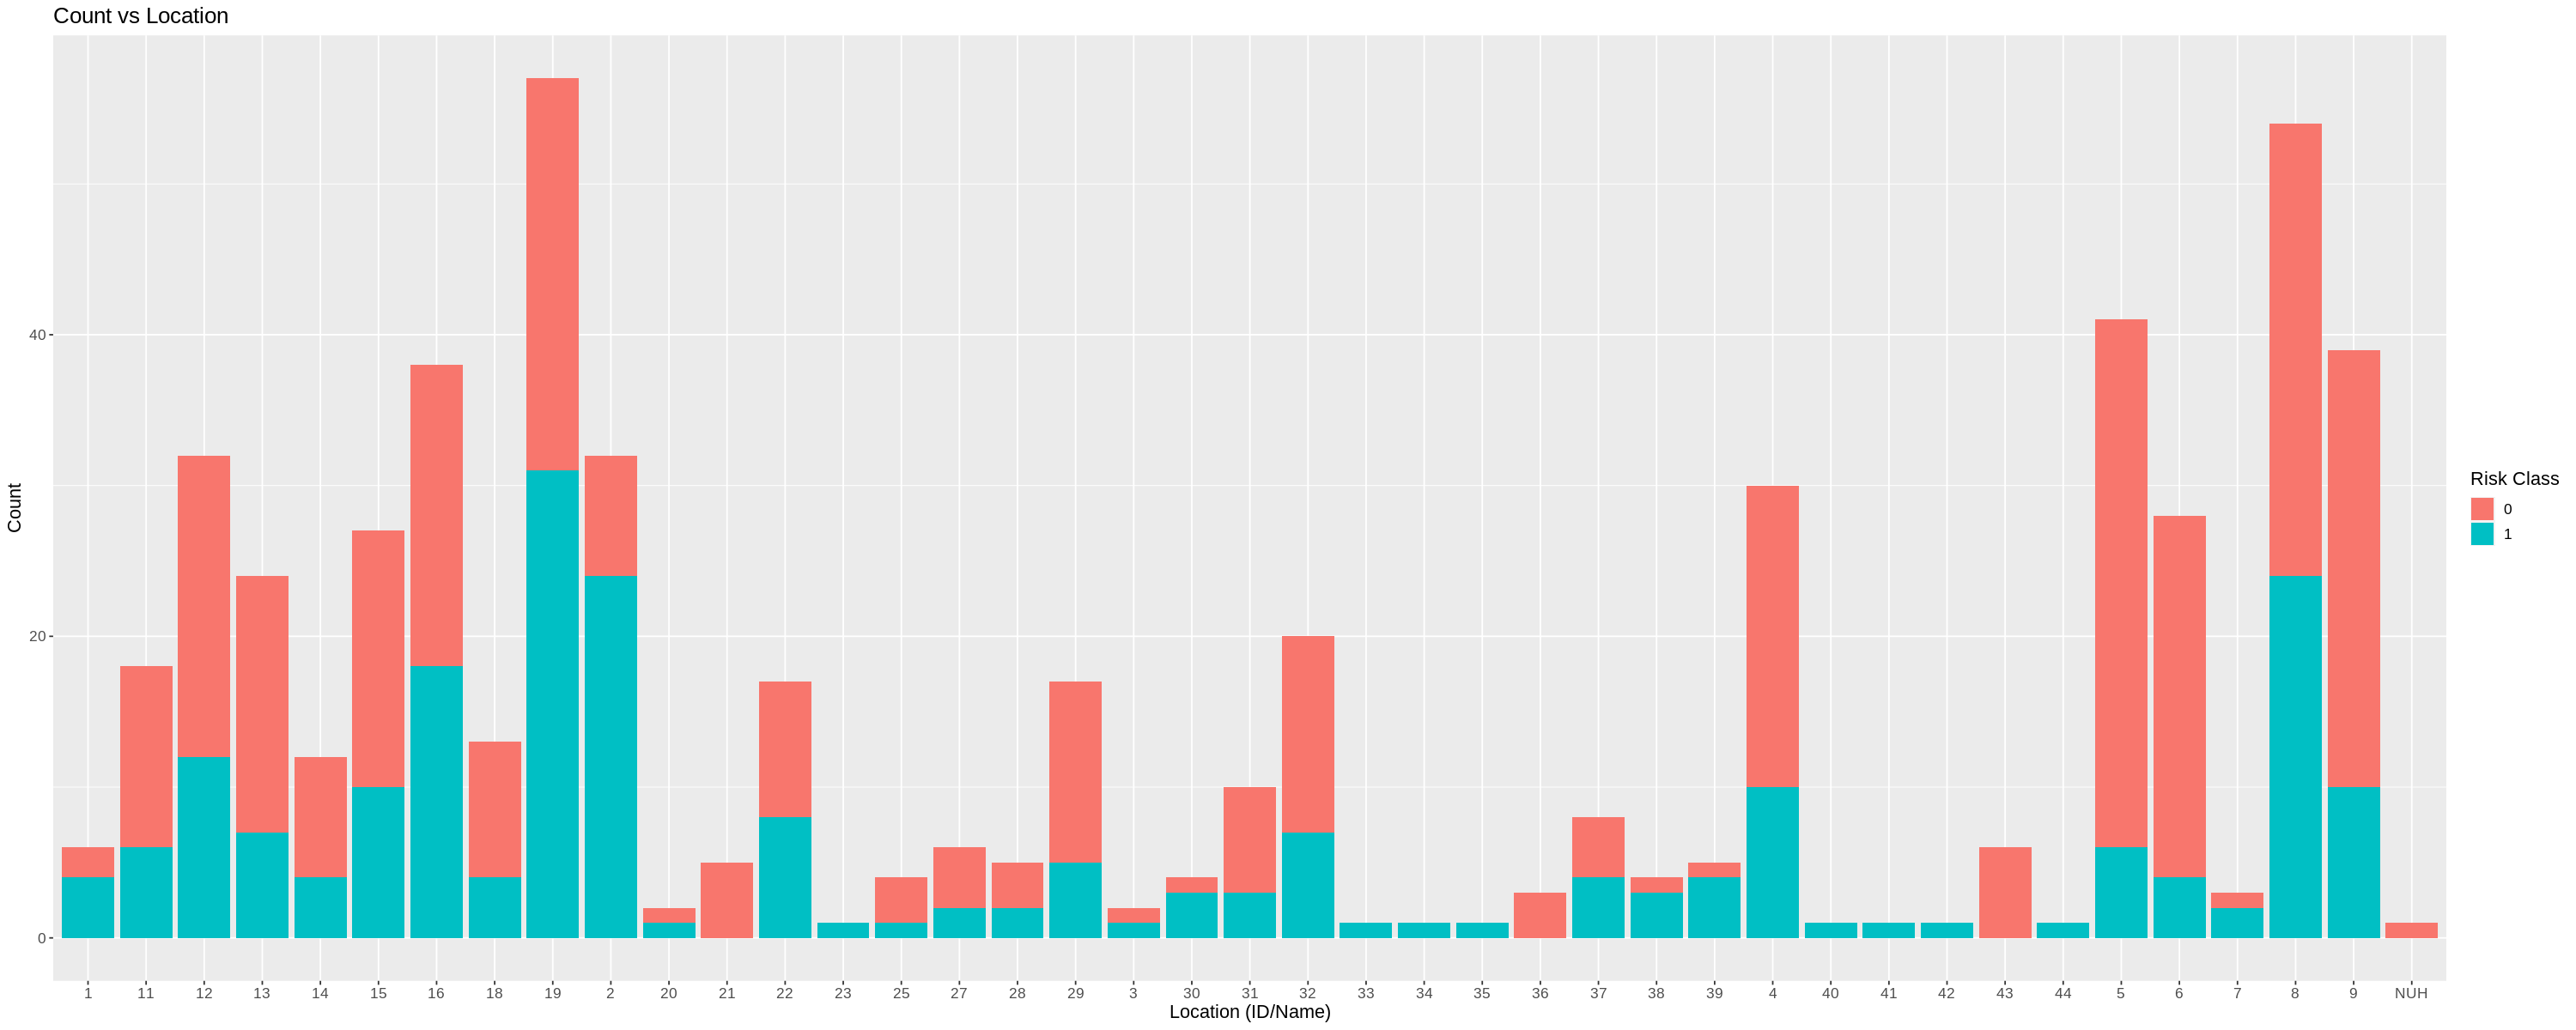

In [11]:
options(repr.plot.width = 25, repr.plot.height = 10) 
location_plot = audit_data_training |> 
    ggplot(aes(x=LOCATION_ID, fill=RISK)) +
        geom_bar() +
        labs(x="Location (ID/Name)", y="Count", fill="Risk Class", title="Count vs Location") +
        theme(text = element_text(size = 13))
location_plot

<b>Figure 1</b>: Plot of counts of Risk Class distribution across Location.

We created a bar plot using the ggplot function, with the x-axis representing "LOCATION_ID" variable and the fill color representing the "RISK" variable. The plot shows the proportion of the counts of risk class for each city/province.

We noticed that there is an imbalance in the number of examples for each location, with some locations having very few data. No clear pattern is observed, and intuitively, the location of the firm should not affect the risk. Therefore, we will remove the location column from the dataset, as it will not be utilized as one of the predictor variables.

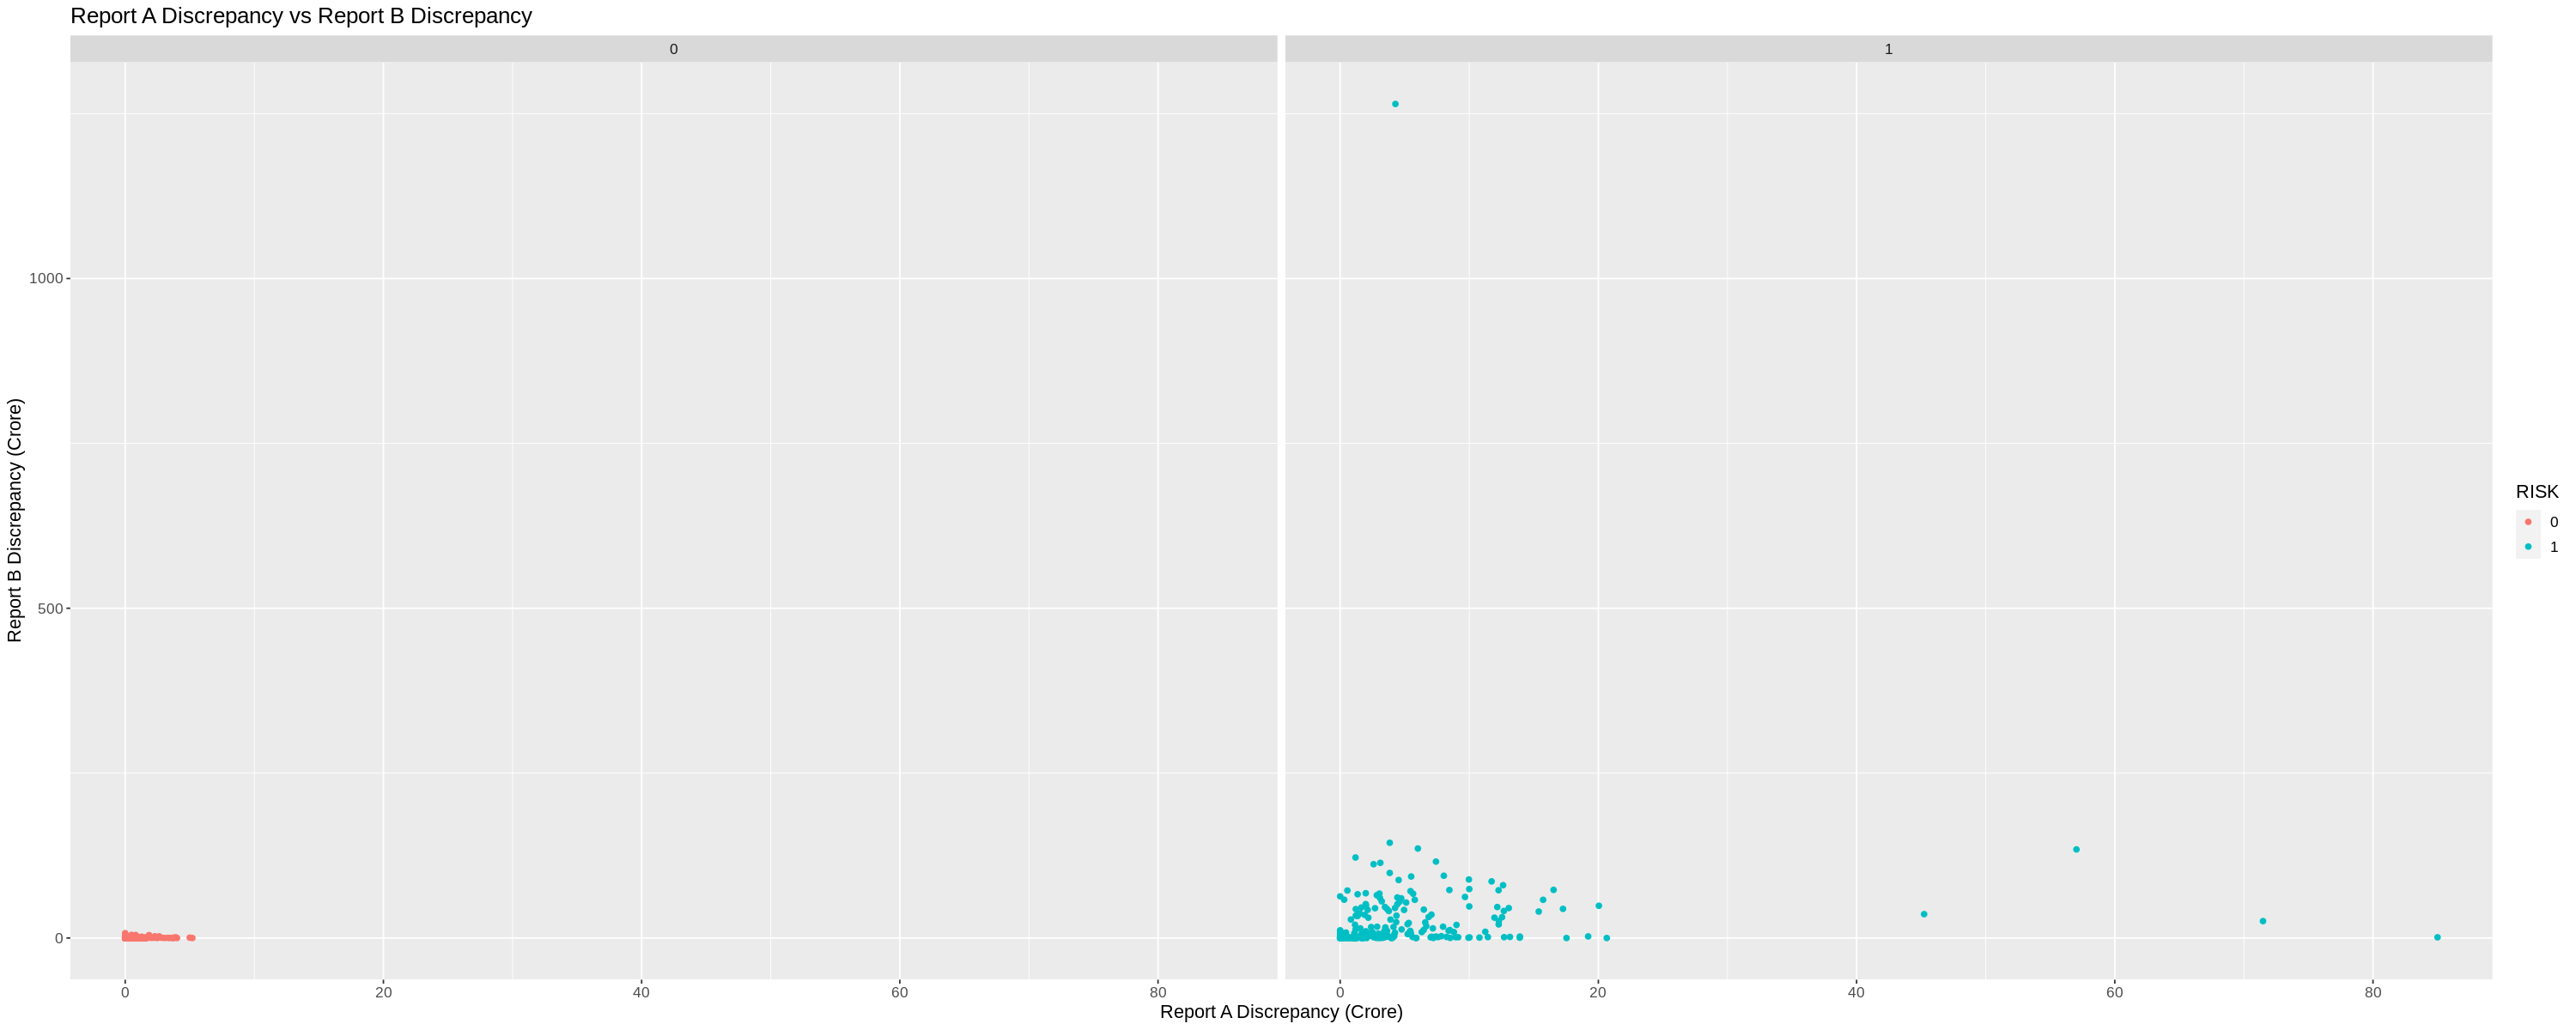

In [12]:
pab_plot = audit_data_training |>
    ggplot(aes(x=PARA_A, y=PARA_B, color=RISK)) +
        geom_point() +
        facet_grid(cols=vars(RISK)) +
        labs(x="Report A Discrepancy (Crore)", y="Report B Discrepancy (Crore)", fill="Risk Class", title="Report A Discrepancy vs Report B Discrepancy") +
        theme(text = element_text(size = 13))
pab_plot

<b>Figure 2</b>

It seems like firms with high discrepancy in A or B are likely to be classified as fraud. However, there are also firms with low discrepancies that are classified as fraud as well. There are some fraud firms who have abnormally high discrepancies. Let's visualize the total discrepancy and see if it is similar.

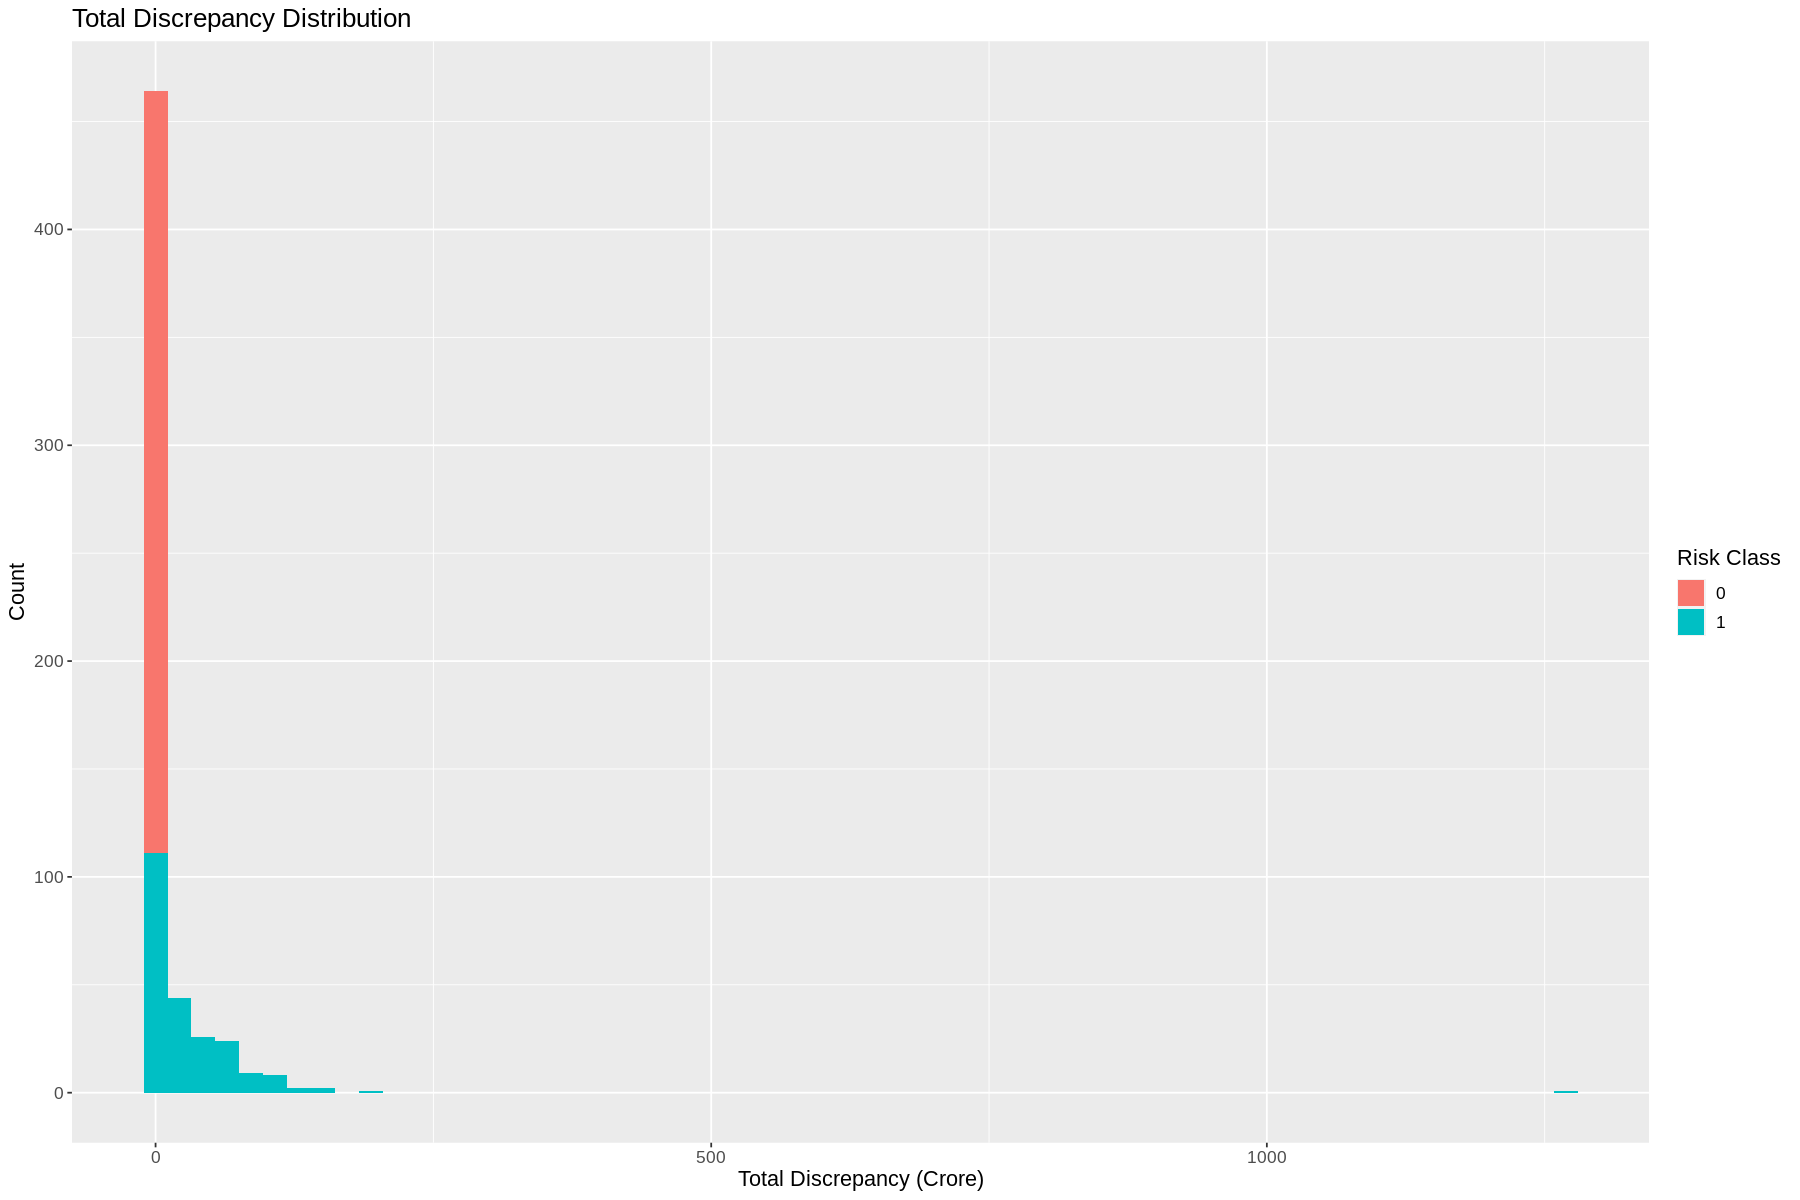

In [13]:
options(repr.plot.width = 15, repr.plot.height = 10) 
total_disc_plot = audit_data_training |>
    ggplot(aes(x=TOTAL, fill=RISK)) +
        geom_histogram(bins=60) +
        labs(x="Total Discrepancy (Crore)", y="Count", fill="Risk Class", title="Total Discrepancy Distribution") +
        theme(text = element_text(size = 13))
total_disc_plot

<b>Figure 3</b>: Plot of counts of Risk Class distribution by Total Discrepancy in crore.

We created a histogram plot using the ggplot function, with the x-axis representing the "TOTAL" variable and the fill color representing the "RISK" variable. This plot illustrates the proportion of counts for each risk class based on the total amount of discrepancy found in other reports (in crores). 

From the visualization, we observed that firms with lower total discrepancy are more likely to be non-fraudulent.

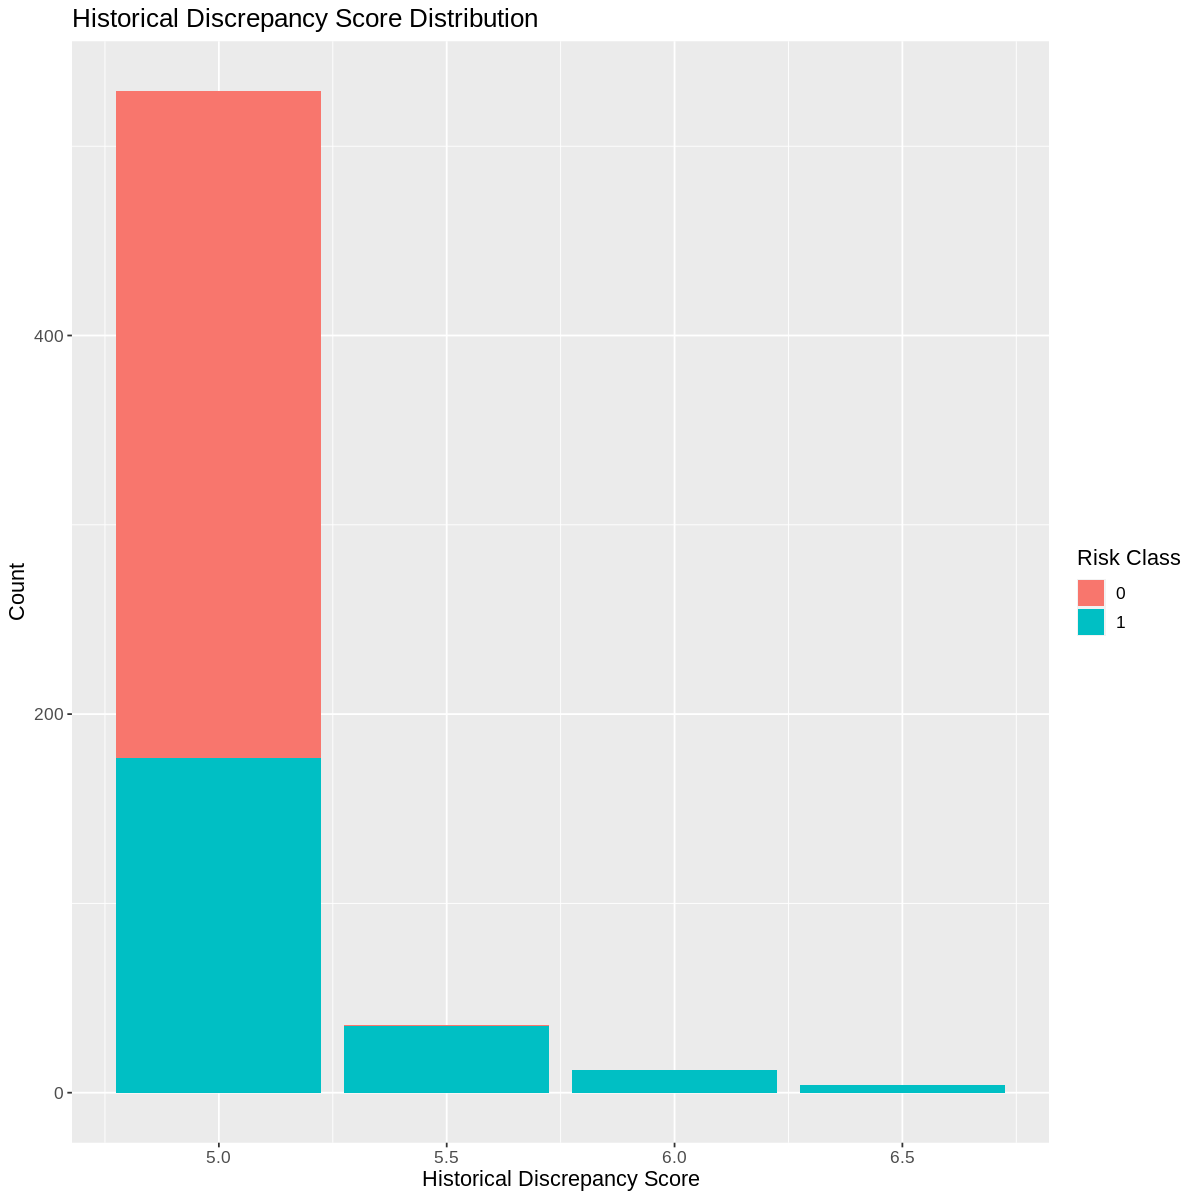

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10) 
numbers_plot = audit_data_training |>
        ggplot(aes(x=NUMBERS, fill=RISK)) +
        geom_bar() +
        labs(x="Historical Discrepancy Score", y="Count", fill="Risk Class", title="Historical Discrepancy Score Distribution") +
        theme(text = element_text(size = 13))
numbers_plot

<b>Figure 4</b>: Plot of counts of Risk Class distribution by Historical Discrepancy Score.

We created a bar plot using ggplot function, with the x-axis representing the "NUMBERS" variable and the fill color representing the "RISK" variable. The plot displays the proportion of the counts for each risk class on different ranges of historical discrepancy scores.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”


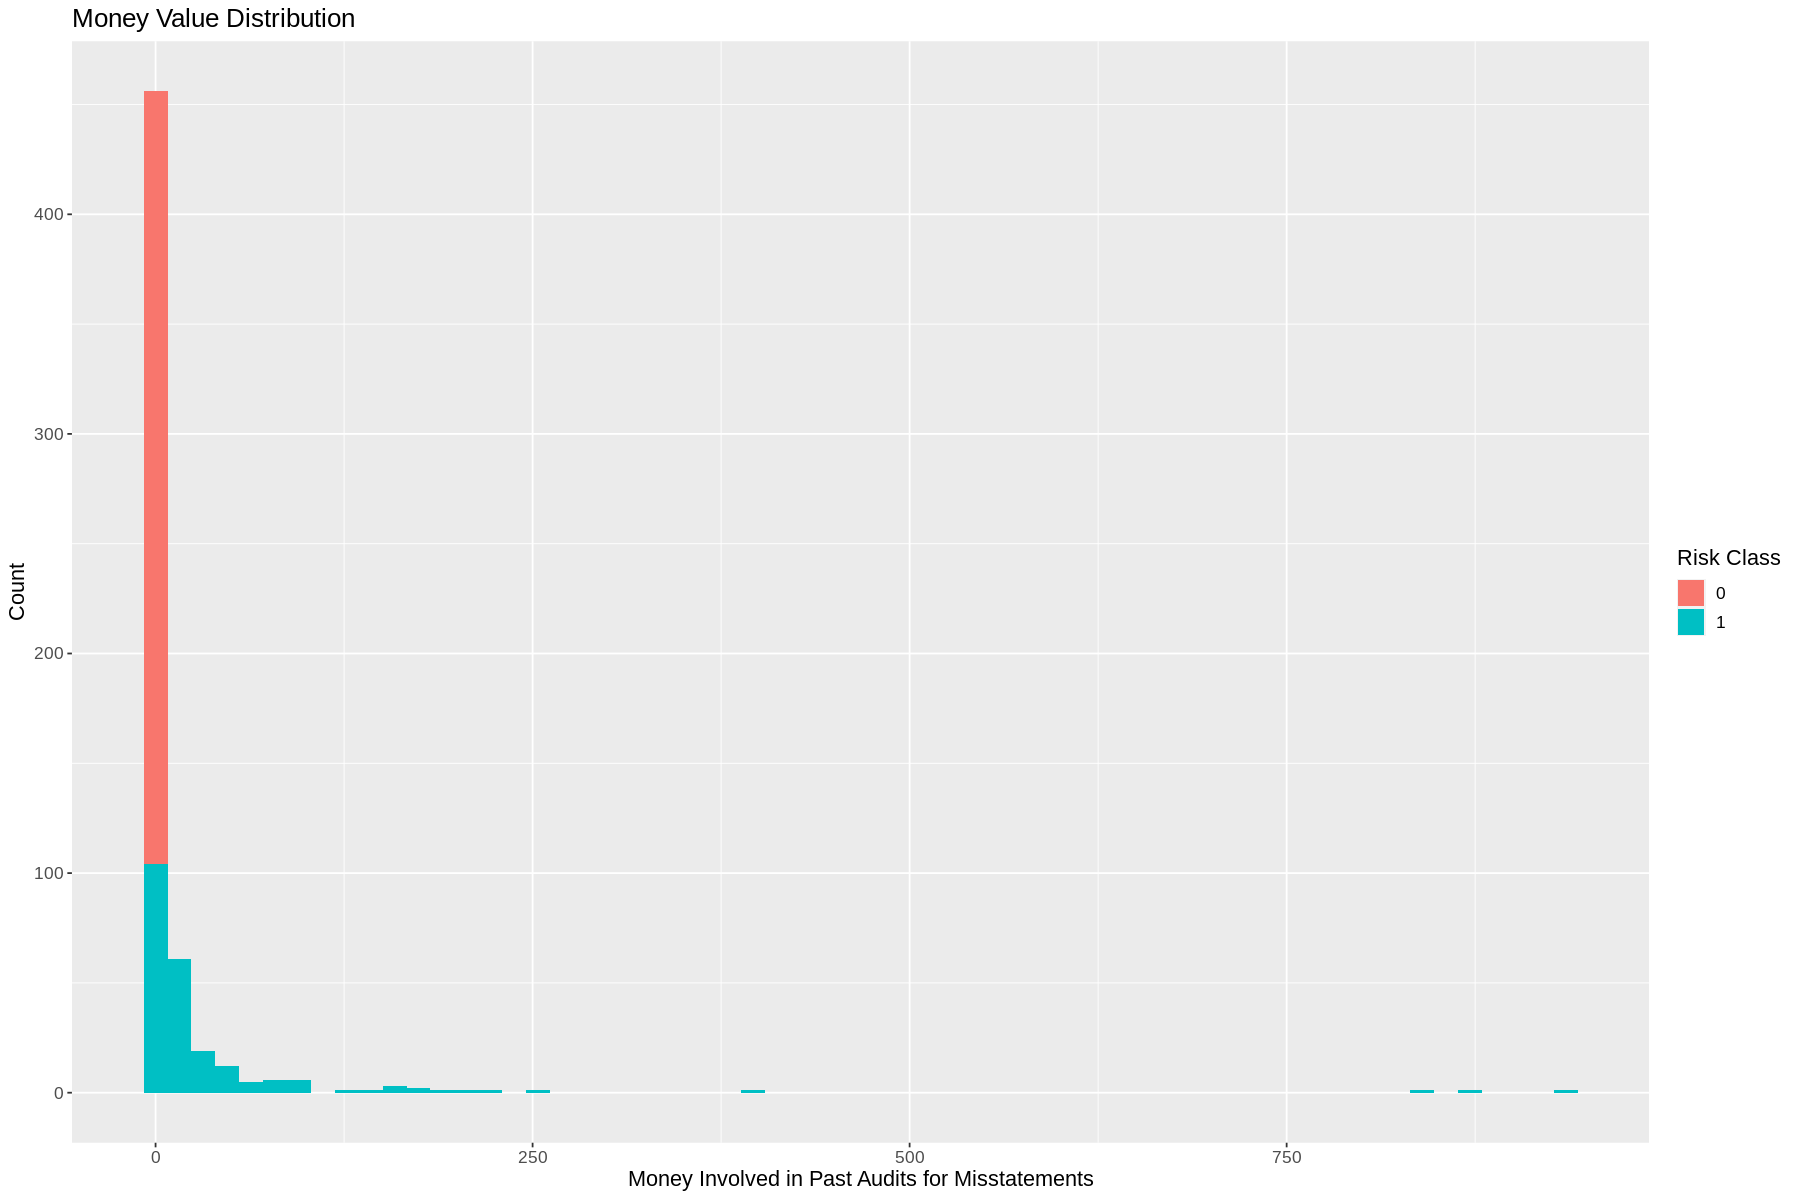

In [15]:
options(repr.plot.width = 15, repr.plot.height = 10) 
money_value_plot = audit_data_training |>
    ggplot(aes(x=MONEY_VALUE, fill=RISK)) +
        geom_histogram(bins=60) +
        labs(x="Money Involved in Past Audits for Misstatements", y="Count", fill="Risk Class", title="Money Value Distribution") +
        theme(text = element_text(size = 13))

money_value_plot

<b>Figure 5</b>

We created a histogram plot using the ggplot function, with the x-axis representing the "MONEY_VALUE" variable and the fill color representing the "RISK" variable. The plot illustrates the proportion of counts for each risk category on the different amounts of money involved in past audit misstatements.

From the visualization, we observed that firms with a high historical discrepancy score are more likely to be fraudulent. Additionally, firms that had a significant amount of money involved in past audits for misstatements are also more likely to be fraudulent.

## Method & Expectations

Based on the EDA, we will be selecting the following variables for our prediction: SECTOR_SCORE, PARA_A, PARA_B, TOTAL, NUMBERS, MONEY_VALUE. We will be using K nearest neighbors to perform classification prediction. The steps are the following:

1. Removing unused columns
2. Create recipe for centering, scaling, and imputing (median) using the training dataset
3. Use 5 fold cross validation to find the best odd value for k between 1 and 21.
4. Train the knn model on the whole training set based on the best value of k.
5. Examine the performance of the model on the training set through ggpair feature graphs and metrics such as accuracy, recall, and precision
6. Examine the performance of the model on the testing set through ggpair feature graphs and metrics such as accuracy, recall, and precision

We expect that firms would be fraud if they have high discrepancy score regardless if it's historical or reports.

## Removing unused columns

In [16]:
audit_training = audit_data_training |> select(-LOCATION_ID)
audit_testing = audit_data_testing |> select(-LOCATION_ID) |> drop_na()

head(audit_training)

SECTOR_SCORE,PARA_A,PARA_B,TOTAL,NUMBERS,MONEY_VALUE,RISK
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,0.51,0.23,0.74,5,0.000,0
3.89,0.00,0.08,0.08,5,0.000,0
3.89,0.00,0.83,0.83,5,2.950,0
3.89,1.81,1.03,2.84,5,0.000,0
3.89,0.94,0.01,0.95,5,0.100,0
3.89,0.00,1.10,1.10,5,0.007,0


<b>Table 5</b>

We removed the "LOCATION_ID" column from the dataset as it was found to be an inadequate predictor variable.

## Center & Scaling

In [17]:
audit_recipe = recipe(RISK ~ ., data = audit_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_median(all_predictors())

We scaled and centered all predictors to ensure that all variables are on a similar scale and have a similar distribution. 

## Hyper Param Tuning & CV

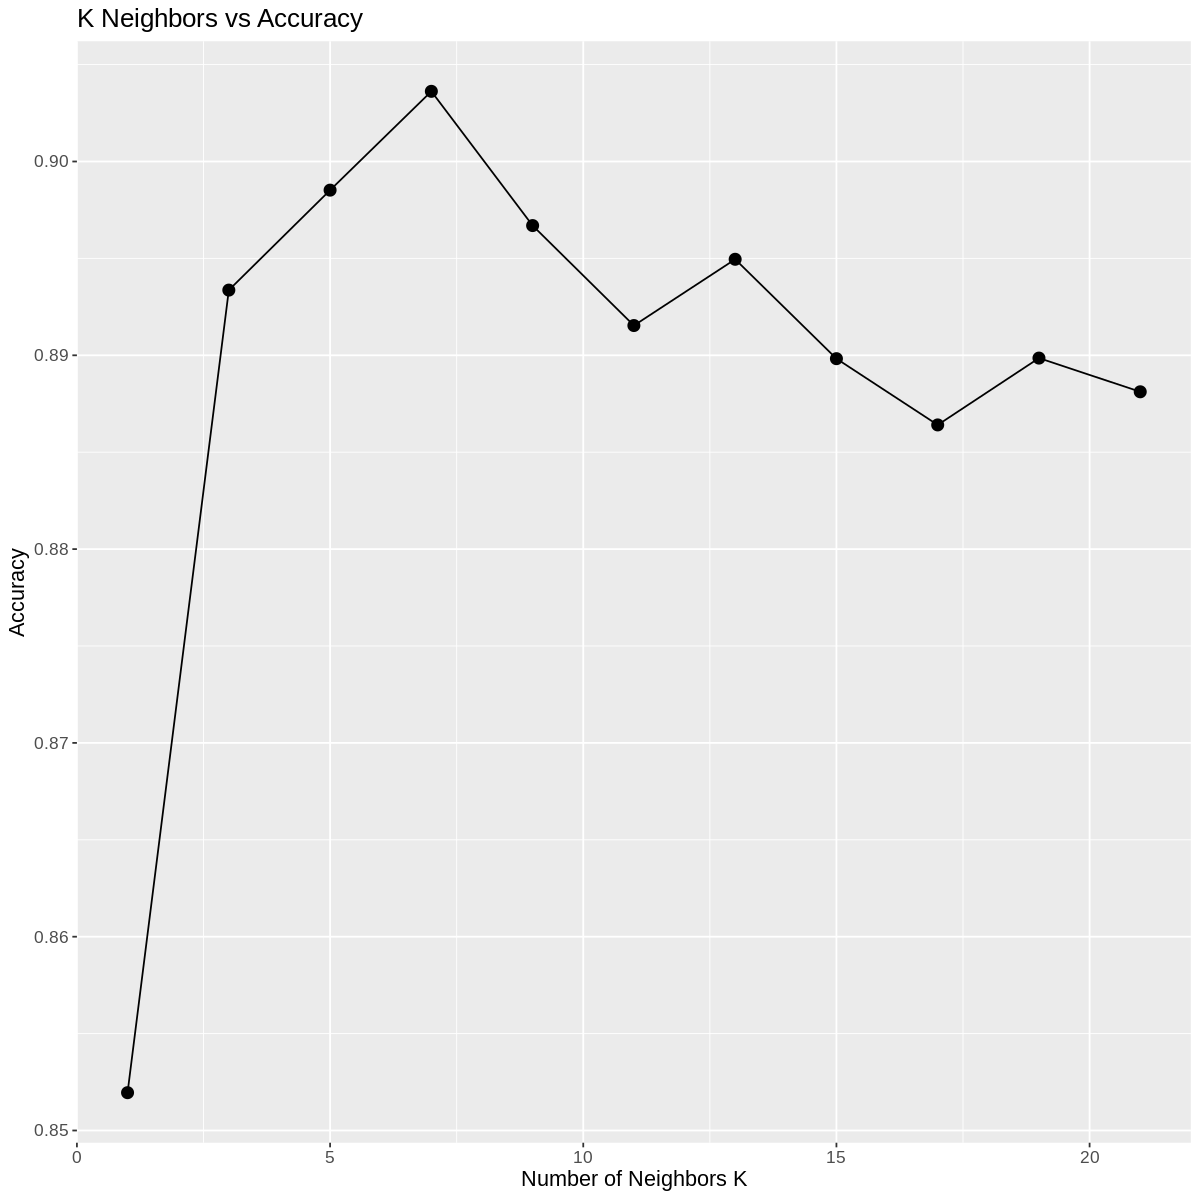

In [18]:
options(repr.plot.width = 10, repr.plot.height = 10)

audit_vfold = vfold_cv(audit_training, v = 5, strata = RISK)

k_vals = tibble(neighbors=seq(from = 1, to = 21, by = 2))

knn_tune = nearest_neighbor(weight_func = "rectangular",  neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_cv = workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = audit_vfold, grid = k_vals) |>
    collect_metrics()

knn_cv_plot = knn_cv |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x=neighbors, y=mean)) +
        geom_point(size=3) +
        geom_line() +
        labs(x="Number of Neighbors K", y="Accuracy", title="K Neighbors vs Accuracy") +
        theme(text = element_text(size = 13))
    
knn_cv_plot

<b>Figure 6</b>

We conducted cross-validation with 5 folds for odd values of k from 1 to 21 and collected performance metrics for each value of K. Then, we generated a plot that displayed the mean accuracy of the KNN model for each k value. Based on the graph, we observed that best K value is somewhere between 5 to 10. 

In [19]:
best_row = knn_cv |> 
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    select(neighbors, mean) |>
    slice(1)

best_k = best_row |>
    select(neighbors) |>
    pull()

best_row

neighbors,mean
<dbl>,<dbl>
7,0.9036195


<b>Table 6</b>

To be more precise, we pull the neighbors with the highest mean from the table, and found the optimal value of K was 7 with the highest accuracy of 0.9086585.

In [20]:
knn_spec = nearest_neighbor(weight_func = "rectangular",  neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

model = workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_spec) |>
    fit(audit_training)

We created a new model and workflow using the optimal value of K. We then fitted this model to our training data.

## Evaluating Model On Training Set

In [21]:
train_predictions = model |>
    predict(audit_training) |>
    bind_cols(audit_training) |>
    mutate(predicted = as_factor(if_else(.pred_class==RISK, RISK, as_factor(2))))
    
multi_metric = metric_set(accuracy, recall, precision, f_meas)
multi_metric(train_predictions, truth = RISK, estimate = .pred_class, event_level = "second")
conf_mat(train_predictions, truth = RISK, estimate = .pred_class)

Warning message in `[<-.factor`(`*tmp*`, i, value = structure(1L, .Label = "2", class = "factor")):
“invalid factor level, NA generated”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9191050
recall,binary,0.8070175
precision,binary,0.9839572
f_meas,binary,0.8867470


          Truth
Prediction   0   1
         0 350  44
         1   3 184

<b>Table 7</b>

We used our trained model to predict the risk class of our training set and generated a table that displays statistical measures of the model's accuracy. The model has an accuracy of 91.91%. However, the recall is much lower. Based on recall, our model is able to identify only 80.70% of the fraud firms in the training set. However, the model is precise such that out of the firms that was predicted to be fraud, 98.395% was actually fraud. In other words, there are a lot of false negatives but few false positives. Overall, the model performs much better than the baseline of predicting the majority class (non fraud), which would have an accuracy of 60.75%.

## Evaluating Model On Test Set

In [22]:
test_predictions = model |>
    predict(audit_testing) |>
    bind_cols(audit_testing)

multi_metric = metric_set(accuracy, recall, precision, f_meas)
multi_metric(test_predictions, truth = RISK, estimate = .pred_class, event_level = "second")
conf_mat(test_predictions, truth = RISK, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9025641
recall,binary,0.7922078
precision,binary,0.9531250
f_meas,binary,0.8652482


          Truth
Prediction   0   1
         0 115  16
         1   3  61

<b>Table 8</b>

We used our trained model to predict the risk class of our testing set and generated a table that displays statistical measures of the model's accuracy. The model has an accuracy of 90.26% on the testing set, which is similar to the training set. The recall is also quite close at 79.22%. The precision for the testing set is a lower by roughly 3% at 95.31%. The number of false negatives are still large while the number of false positives are small. The model still performs well above the baseline.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


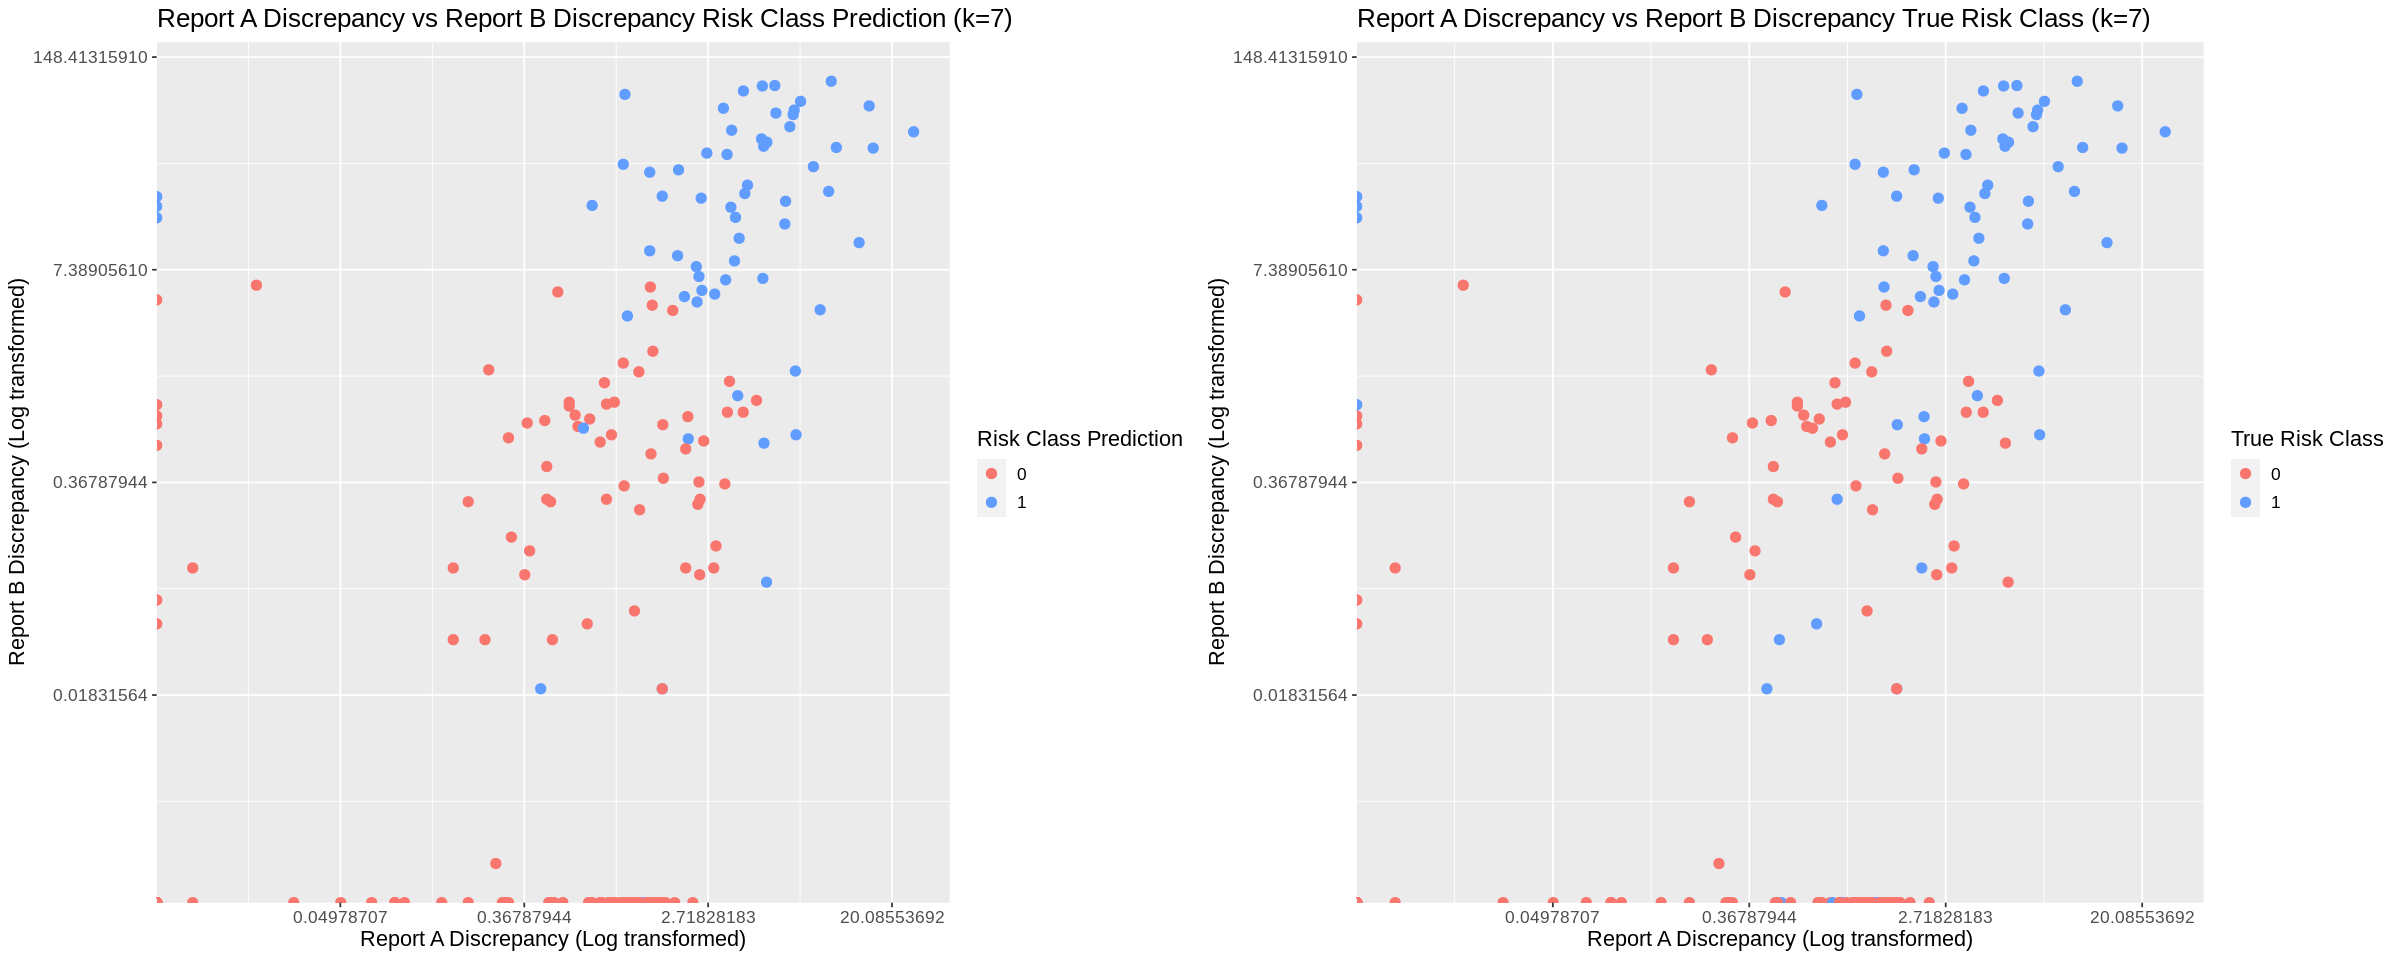

In [23]:
options(repr.plot.width = 20, repr.plot.height = 8)
pred_plot_report = ggplot(test_predictions, aes(x=PARA_A, y=PARA_B)) +
    geom_point(aes(color=.pred_class), size=2.5) +   
    labs(x="Report A Discrepancy (Log transformed)",
         y="Report B Discrepancy (Log transformed)",
         color="Risk Class Prediction",
         title="Report A Discrepancy vs Report B Discrepancy Risk Class Prediction (k=7)") +
    theme(text = element_text(size = 13)) +
    scale_color_manual(values=c("#F8766D", "#619CFF", "#5A5A5A")) +
    scale_x_continuous(trans = "log") +
    scale_y_continuous(trans = "log") 

true_plot_report = ggplot(test_predictions, aes(x=PARA_A, y=PARA_B)) +
    geom_point(aes(color=RISK), size=2.5) +   
    labs(x="Report A Discrepancy (Log transformed)",
         y="Report B Discrepancy (Log transformed)",
         color="True Risk Class",
         title="Report A Discrepancy vs Report B Discrepancy True Risk Class (k=7)") +
    theme(text = element_text(size = 13)) +
    scale_color_manual(values=c("#F8766D", "#619CFF", "#5A5A5A")) +
    scale_x_continuous(trans = "log") +
    scale_y_continuous(trans = "log") 

plot_grid(pred_plot_report, true_plot_report, ncol=2)

<b>Figure 7</b>

To visualize the outcome of our predictions in relation to the discrepancies in "Report A" and "Report B," we created two separate scatter plots. Both plots featured the same x-axis, representing the discrepancy in "Report A," and the y-axis, representing the discrepancy in "Report B." In the left graph, we plotted the predicted risk classes, while in the right graph, we plotted the actual risk classes from the dataset. To enhance clarity and distinction, we assigned different colors to the points based on their corresponding risk classes.

By observing and comparing the scatter plots, we can easily identify any patterns or discrepancies between the predicted risk classes and the ground truth. This visual analysis helps us understand how well our predictions align with the actual data, specifically in relation to the discrepancies in "Report A" and "Report B".

We encountered warnings related to the presence of infinite values. This issue arose because the points in the plot were spread too widely, causing some of them to overlap and making it difficult to display them clearly. To address this, we scaled the axes by logarithmic transformation to improve the visualization of the points. However, since the logarithm of zero can not be defined, resulting in the warning being generated.

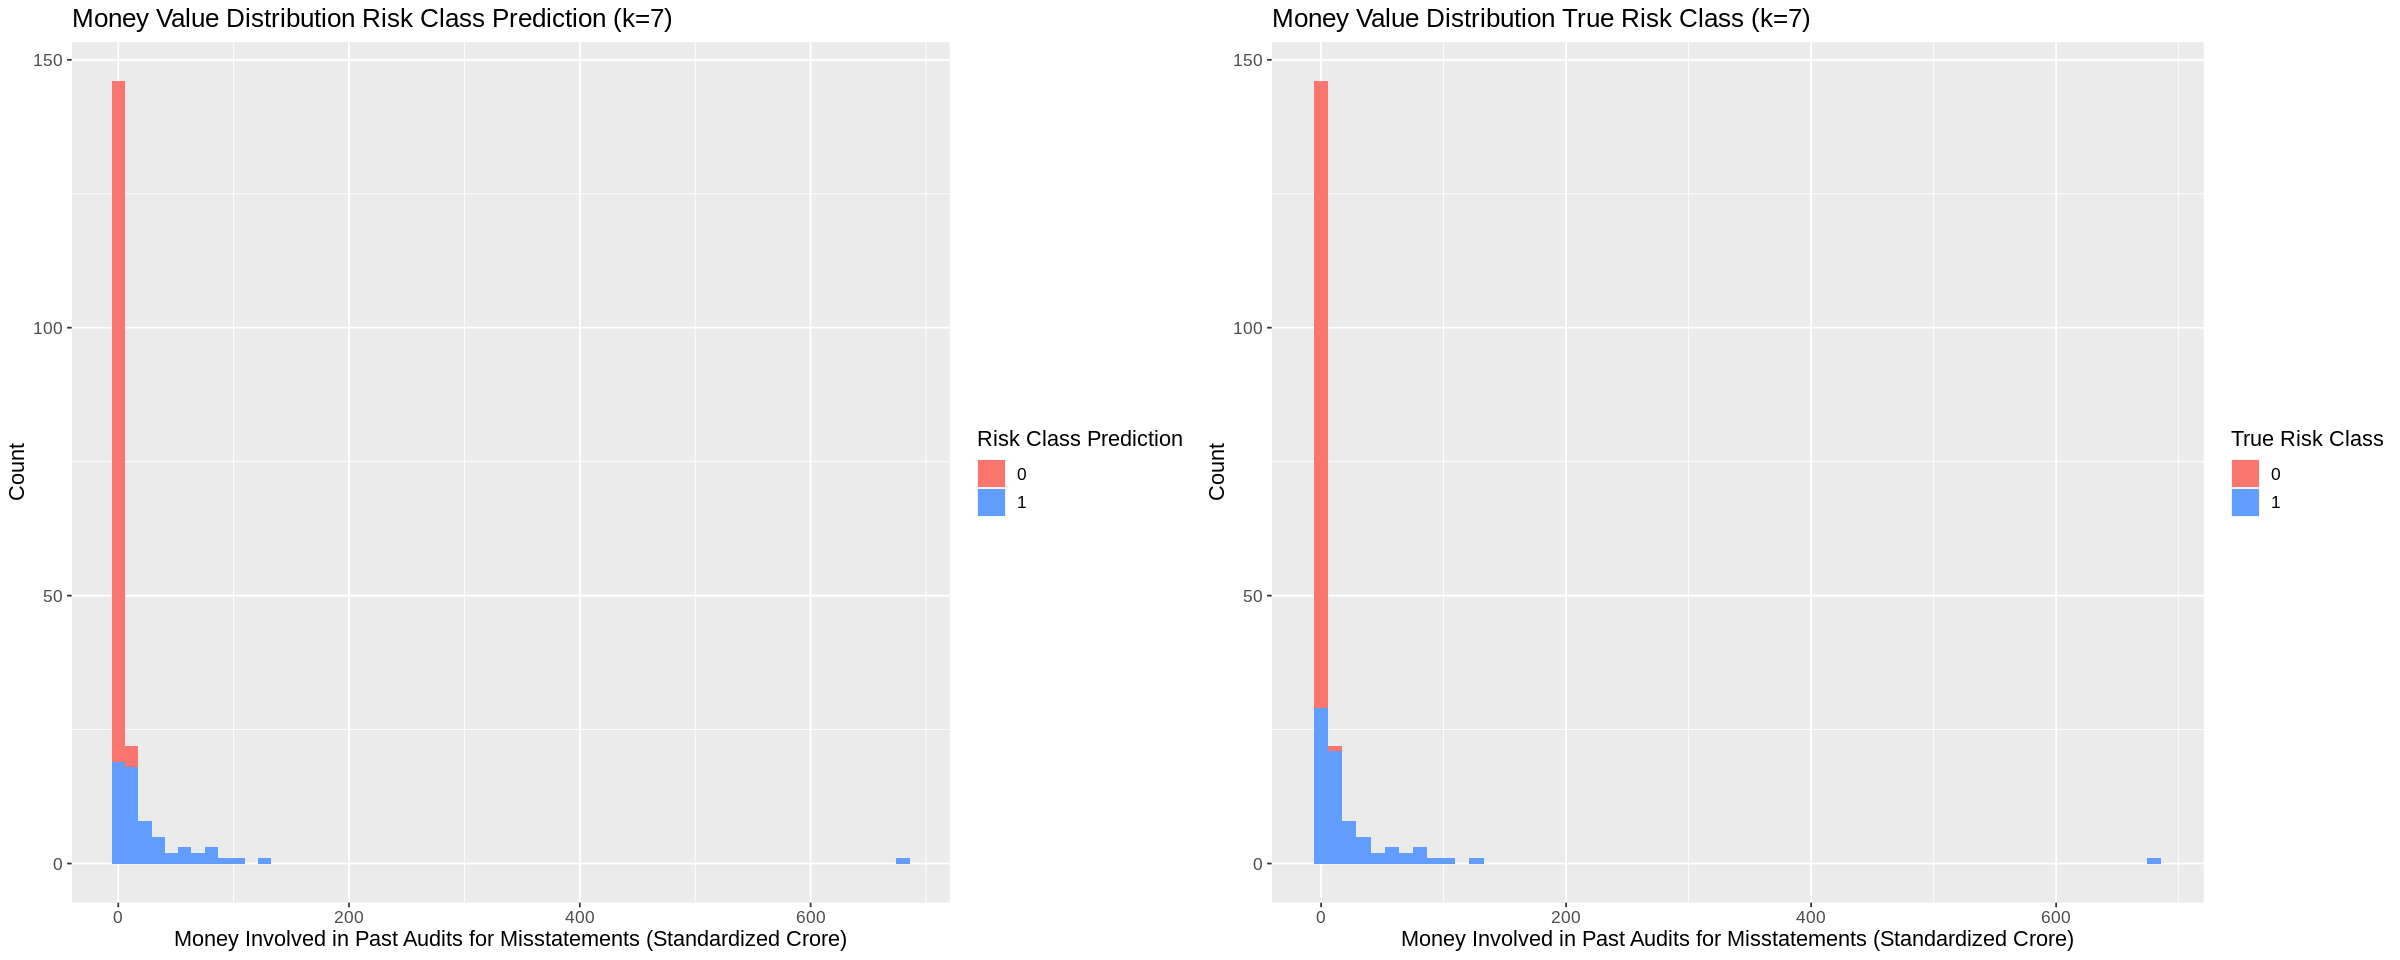

In [24]:
pred_plot_money_val = ggplot(test_predictions, aes(x=MONEY_VALUE, fill=.pred_class)) +
    geom_histogram(bins=60) +
    labs(x="Money Involved in Past Audits for Misstatements (Standardized Crore)",
         y="Count", 
         fill="Risk Class Prediction", 
         title="Money Value Distribution Risk Class Prediction (k=7)") +
    theme(text = element_text(size = 13)) +
    scale_fill_manual(values=c("#F8766D", "#619CFF", "#5A5A5A"))

true_plot_money_val = ggplot(test_predictions, aes(x=MONEY_VALUE, fill=RISK)) +
    geom_histogram(bins=60) +
    labs(x="Money Involved in Past Audits for Misstatements (Standardized Crore)",
         y="Count", 
         fill="True Risk Class", 
         title="Money Value Distribution True Risk Class (k=7)") +
    theme(text = element_text(size = 13)) +
    scale_fill_manual(values=c("#F8766D", "#619CFF", "#5A5A5A"))

plot_grid(pred_plot_money_val, true_plot_money_val, ncol=2)

<b>Figure 8</b>

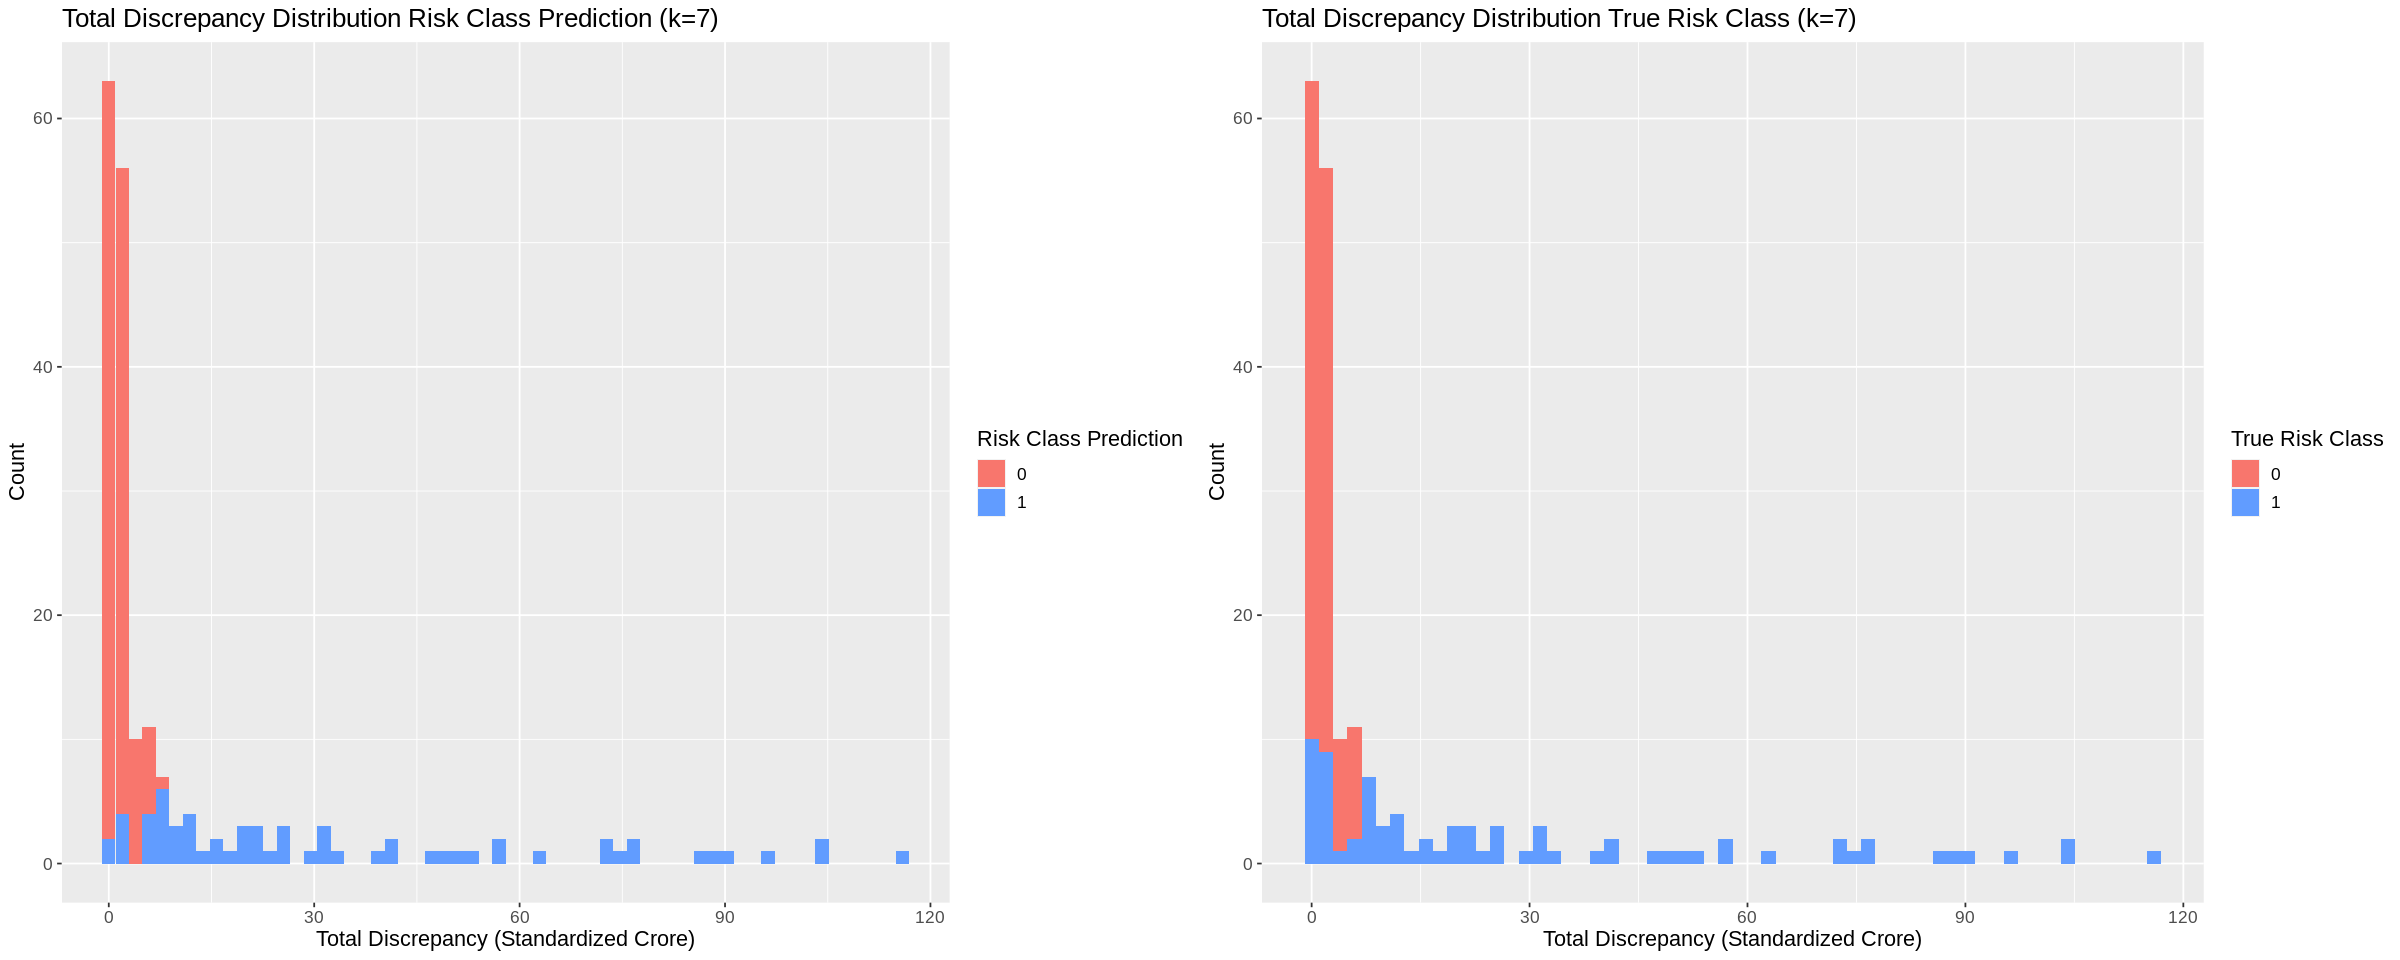

In [25]:
pred_plot_total = ggplot(test_predictions, aes(x=TOTAL, fill=.pred_class)) +
    geom_histogram(bins=60) +
    labs(x="Total Discrepancy (Standardized Crore)",
         y="Count", 
         fill="Risk Class Prediction", 
         title="Total Discrepancy Distribution Risk Class Prediction (k=7)") +
    theme(text = element_text(size = 13)) +
    scale_fill_manual(values=c("#F8766D", "#619CFF", "#5A5A5A"))

true_plot_total = ggplot(test_predictions, aes(x=TOTAL, fill=RISK)) +
    geom_histogram(bins=60) +
    labs(x="Total Discrepancy (Standardized Crore)",
         y="Count", 
         fill="True Risk Class", 
         title="Total Discrepancy Distribution True Risk Class (k=7)") +
    theme(text = element_text(size = 13)) +
    scale_fill_manual(values=c("#F8766D", "#619CFF", "#5A5A5A"))

plot_grid(pred_plot_total, true_plot_total, ncol=2)

<b>Figure 9</b>

# Discussion

1. summarize what you found
2. discuss whether this is what you expected to find?
3. discuss what impact could such findings have?
4. discuss what future questions could this lead to?

# References